# Scorecard development with `optbinning` and lasso

As a data scientist working for a bank, it's a daily task to develop credit risk models to classify the applicants as low risk or high risk clients.

Scorecard is a commonly used tool to develop an algorithm to compute applicants' risk scores. At this time of data age, data scientists could face hundreds even thousands variables that can be used to train the model. Traditionally model developers would use step-wise methods to add or delete variables to the model until there is no reason to continue the process. What I found very convenient is to use the L-1 regularization method (also known as lasso) and cross-validation to eliminate redundant variables and find the best model.

In this article, I am going to mention the concepts of scorecard, Lasso and crossvalidation (hyperparameter tuning) and how I used these techniques to develop a scorecard during my daily work.

## Scorecard

One of the significant differences between scorecard and logistic regression is that you first bin the features and use $WOE$ instead of the original features to calculate the $PD$ (probability of default). In the end, you will get a score from a scorecard instead of a probabilty. So there is some procedure to convert the model-generated probability to an integer score. Thay way your bank manager can commucate with you about your credit score instead of a bizzare $0.897$ probability. 

## Too many features

Nowadays we face an enviroment where there is too much data instead of too little data to model with. In the process of modeling, we need to choose the most important features for our target and eliminate those superfluous features. For example, some features can be highly correlated and one of them is enough for the. In statistical modeling, we call this phenomenon as multicollinearity. When we are estimationg a regression model, multicollinearity can lead to inflated standard errors of the estimated parameters and result in unstable/bad models.

In this example, I am going to introduce the L1 regularization that is used to alleviate the extent of feature redundancy.

$$\text{Loss} = \text{Original Loss} + \lambda \sum |w_i|$$

Here:

- $\text{Original Loss}$ is the loss without regularization (e.g., mean squared error, in the logistic regression it could be the binary cross-entropy loss).
- $\lambda$ is a regularization parameter that you can tune. It controls the strength of the penalty. And in later sections, we would use corss-validation to find the best $\lambda$.
- $\sum |w_i|$ is the sum of the absolute values of the coefficients w_i.



## How to do it in python

I am going to demonstrate how I would do it in Python with some simulated data. In practice, you will find yourself facing a dataset with millions of clients and thousands of features. However the methodology is the same.

In [4]:
import numpy as np
import pandas as pd
from optbinning import OptimalBinning, BinningProcess

from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

# Parameters
n_samples = 10000  # Number of samples
n_features = 50  # Number of features
n_informative = 15  # Number of informative features
n_redundant = 2  # Number of redundant features
n_classes = 2  # Number of classes
weights = [0.9, 0.1]

# Generate the data
X, y = make_classification(n_samples=n_samples,
                           n_features=n_features,
                           n_informative=n_informative,
                           n_redundant=n_redundant,
                           n_classes=n_classes,
                           weights=weights,
                           random_state=77)

# Convert to DataFrame for easier manipulation
col_names = [f'feature_{i}' for i in range(n_features)]
df = pd.DataFrame(X, columns=col_names)
df['y'] = y

# Display the first few rows of the dataframe
print(df.head())

   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   3.080523  -2.222642   0.586273   0.165642  -0.680589  -0.073288   
1   1.735613   4.247614  -0.156868   0.216549  -1.023063   2.152543   
2   1.725620   1.331498  -0.810434  -0.959882   2.480232  -0.711417   
3   1.010512  -5.338740   1.233311   0.662510   0.681362   0.218692   
4  -1.302434   2.176737  -0.808271   0.774462  -0.592410  -0.158665   

   feature_6  feature_7  feature_8  feature_9  ...  feature_41  feature_42  \
0  -0.428355   0.958035  -5.519702   0.474460  ...    0.137293   -2.154975   
1   1.321979   0.747561  -0.975258   0.900816  ...    1.299570   -1.293430   
2  -0.755270   0.460768   0.574454   1.879138  ...   -0.015032    0.096618   
3   2.307052   0.575638  -0.093026  -1.002429  ...    1.522615    0.327769   
4  -0.761512  -0.222382  -0.013585   1.215514  ...    1.174782   -0.913200   

   feature_43  feature_44  feature_45  feature_46  feature_47  feature_48  \
0   -0.734805    1.396048  

<Axes: >

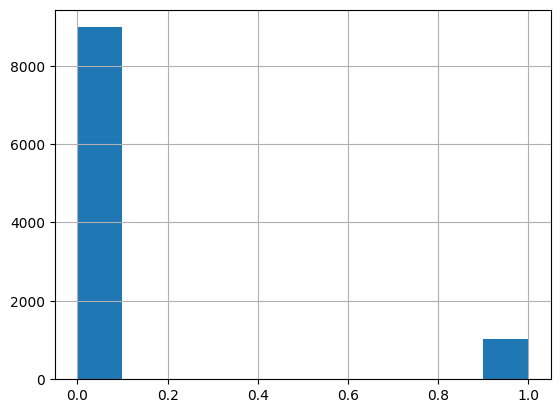

In [5]:
df.y.hist()

/var/folders/jy/yrf0_2sx3v3gzgjl01s2_8sc0000gn/T/ipykernel_26643/1951943532.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="y"
/var/folders/jy/yrf0_2sx3v3gzgjl01s2_8sc0000gn/T/ipykernel_26643/1951943532.py:4: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(x="y"


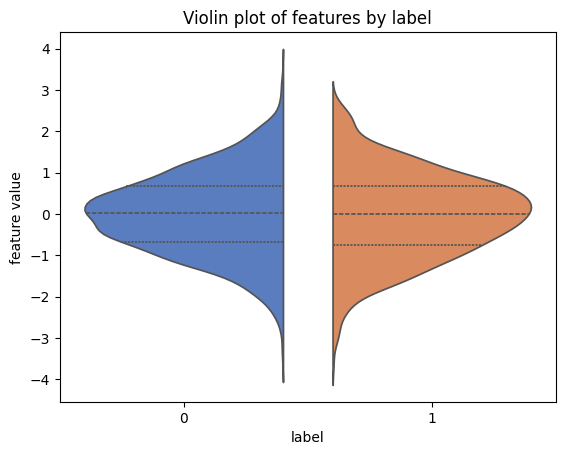

In [6]:
import seaborn as sns

# Create a violin plot with customizations
sns.violinplot(x="y"
               , y="feature_3"
               , data=df
               , split=True
               , inner="quartile"
               , palette="muted"
               , scale="count")

# Add a title and labels
plt.title('Violin plot of features by label')
plt.xlabel('label')
plt.ylabel('feature value')

# Show the plot
plt.show()

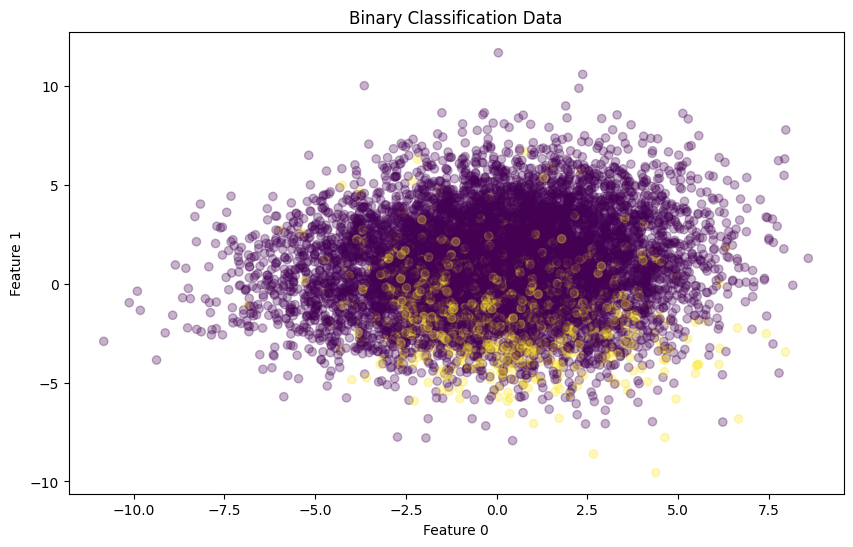

In [30]:
# Visualize the first two features
plt.figure(figsize=(10, 6))
plt.scatter(df['feature_20'], df['feature_32'], c=df['y'], cmap='viridis', alpha=0.3)
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.title('Binary Classification Data')
plt.show()

In [8]:
# split into training, validation and test set

from sklearn.model_selection import train_test_split

# # Split the data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# df_test is going to be our left out test sample
df_train_, df_test = train_test_split(df
                 , test_size=0.15
                 , random_state=77)

df_train, df_val = train_test_split(df_train_
                 , test_size=0.2
                 , random_state=77)

print(f'The sizes of train, validation and test sets are {df_train.shape[0]}, {df_val.shape[0]}, {df_test.shape[0]}.')

The sizes of train, validation and test sets are 6800, 1700, 1500.


## The Binning Process

We will use [OptBinning](http://gnpalencia.org/optbinning/) to do the binning part. If you are interested, you can visit the home page of the package. Here is the introduction from thier website.

> The optimal binning is the optimal discretization of a variable into bins given a discrete or continuous numeric target. OptBinning is a library written in Python implementing a rigorous and flexible mathematical programming formulation to solve the optimal binning problem for a binary, continuous and multiclass target type, incorporating constraints not previously addressed.

In [9]:
# from ydata_profiling import ProfileReport

# profile = ProfileReport(df, title="Pandas Profiling Report")
# profile

In [10]:
# # Convert to DataFrame for easier manipulation (optional)
# df_train = pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(n_features)])
# df_train['y'] = y_train

# df_val = pd.DataFrame(X_val, columns=[f'feature_{i}' for i in range(n_features)])
# df_val['y'] = y_val

# Display the shape of the resulting datasets
print(f'Training set shape: {df_train.shape}')
print(f'Validation set shape: {df_val.shape}')


selection_criteria = {"iv": {"min": 0.02}}

binning_process = BinningProcess(variable_names=col_names
                                 , min_prebin_size=0.01
                                 , max_n_bins=None
                                 , min_bin_size=0.05
                                 , selection_criteria=selection_criteria
                                 , n_jobs=None)

variable_names = col_names

binning_process.fit(df_train.loc[:, variable_names], df_train.loc[:, 'y'])

df_train_woe = binning_process.transform(df_train.loc[:, variable_names]
                                         , metric='woe'
                                         , metric_missing='empirical')

df_train_woe.head()

Training set shape: (6800, 51)
Validation set shape: (1700, 51)


,feature_0,feature_1,feature_4,feature_9,feature_12,feature_15,feature_16,feature_17,feature_18,feature_19,...,feature_31,feature_32,feature_34,feature_35,feature_36,feature_37,feature_42,feature_45,feature_46,feature_48
3803,-0.198717,-0.00303,-0.104984,-0.022752,0.039165,0.050108,-0.096567,0.301457,0.070496,0.118410,...,0.258165,2.065892,0.337535,0.009863,0.013160,-0.005671,0.318104,0.039315,-0.359713,-0.103907
8835,-0.488738,-0.00303,0.155568,-0.022752,-0.050594,0.116010,0.477915,0.413342,0.056234,0.495249,...,0.258165,2.065892,0.337535,-0.018696,0.013160,-0.316992,0.012626,0.306719,0.622712,-0.103907
5160,-0.089629,-0.05241,-0.097076,-0.022752,0.039165,0.050108,0.477915,-0.224455,0.056234,-0.057077,...,0.258165,0.165780,-0.046789,-0.018696,-0.051565,0.331291,0.012626,0.306719,0.180705,0.068626
3671,0.268837,-0.05241,-0.139101,-0.022752,0.134657,0.050108,-0.096567,0.301457,-0.130562,-0.057077,...,-0.120298,2.065892,-0.229642,-0.018696,0.013160,-0.316992,-0.289836,-0.925294,-0.919692,-0.103907
3082,-0.198717,-0.05241,0.155568,-0.022752,-0.050594,-0.182615,-0.066231,0.413342,-0.209557,0.118410,...,-0.120298,0.865998,-0.046789,-0.018696,0.013160,-0.005671,0.012626,0.039315,-0.127682,0.068626


In [11]:
variables_bin_selected = binning_process.get_support(names=True)

# the binning table for one variable
binning_process.get_binned_variable(variables_bin_selected[0]).binning_table.build(add_totals=True)

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, -2.91)",602,0.088529,507,95,0.157807,-0.488738,0.025606,0.003169
1,"[-2.91, -2.26)",394,0.057941,350,44,0.111675,-0.089629,0.000482,0.000060
2,"[-2.26, -1.78)",432,0.063529,405,27,0.062500,0.544678,0.015190,0.001876
3,"[-1.78, -0.44)",1548,0.227647,1423,125,0.080749,0.268837,0.014786,0.001843
4,"[-0.44, 0.96)",1597,0.234853,1453,144,0.090169,0.1482,0.004863,0.000607
5,"[0.96, 2.15)",999,0.146912,884,115,0.115115,-0.123847,0.002367,0.000296
6,"[2.15, inf)",1228,0.180588,1077,151,0.122964,-0.198717,0.007714,0.000963
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,6800,1.000000,6099,701,0.103088,,0.071009,0.008814


In [12]:
binning_process.get_binned_variable(variables_bin_selected[0]).binning_table.analysis()

binning_process.get_binned_variable(variables_bin_selected[4]).binning_table.iv

binning_process.get_binned_variable(variables_bin_selected[4]).binning_table.quality_score

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.14690489
    IV (Jeffrey)             0.07100853
    JS (Jensen-Shannon)      0.00881356
    Hellinger                0.00884463
    Triangular               0.03501004
    KS                       0.05792980
    HHI                      0.17640489
    HHI (normalized)         0.07345550
    Cramer's V               0.08184735
    Quality score            0.05486914

  Monotonic trend                valley

  Significance tests

    Bin A  Bin B  t-statistic  p-value  P[A > B]  P[B > A]
        0      1     4.220505 0.039938  0.982381  0.017619
        1      2     6.342284 0.011789  0.994754  0.005246
        2      3     1.587066 0.207746  0.092064  0.907936
        3      4     0.891725 0.345010  0.171784  0.828216
        4      5     4.258142 0.039063  0.020053  0.979947
        5      6     0.3

0.0019503684739798721

In [13]:
# logistic regression

from sklearn.model_selection import GridSearchCV

C_grid = np.logspace(-4, 4, 10)

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='l1', solver='liblinear')

from sklearn.metrics import roc_auc_score

param_grid = {'C': C_grid}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

grid_search.fit(df_train_woe, df_train.loc[:, 'y'])

best_model = grid_search.best_estimator_
best_C = grid_search.best_params_['C']

df_coef = pd.DataFrame({'var': df_train_woe.columns, 'coef': best_model.coef_[0]})

df_coef

,var,coef
0,feature_0,-0.575798
1,feature_1,-0.994443
2,feature_4,-1.068297
3,feature_9,-0.944405
4,feature_12,-0.957070
5,feature_15,-1.096844
6,feature_16,-0.902387
7,feature_17,-0.795004
8,feature_18,0.065639
9,feature_19,-0.853095


In [14]:
vars_to_delete = df_coef.loc[df_coef.coef > 0, 'var'].tolist()
vars_to_keep = df_coef.loc[df_coef.coef < 0, 'var'].tolist()

len(vars_to_delete), len(vars_to_keep)

(1, 21)

(array([4678.,  934.,  463.,  278.,  160.,  110.,   74.,   51.,   39.,
          13.]),
 array([8.54370765e-05, 9.36658373e-02, 1.87246237e-01, 2.80826638e-01,
        3.74407038e-01, 4.67987438e-01, 5.61567838e-01, 6.55148238e-01,
        7.48728638e-01, 8.42309039e-01, 9.35889439e-01]),
 <BarContainer object of 10 artists>)

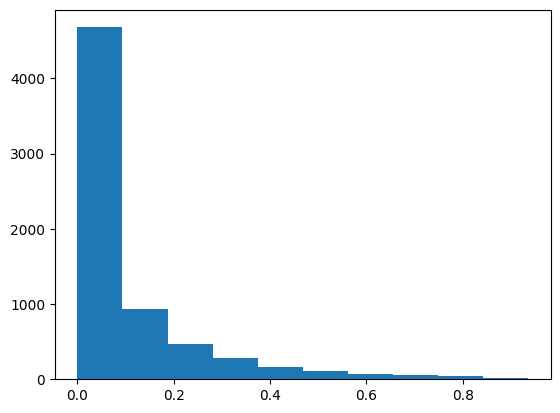

In [15]:
# 分数分布
import matplotlib.pyplot as plt

plt.hist(best_model.predict_proba(df_train_woe)[:, 1])

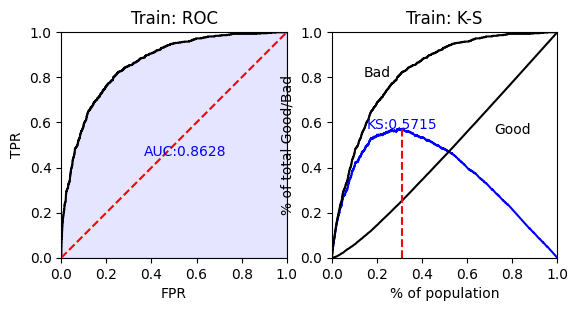

{'KS': 0.5715,
 'AUC': 0.8628,
 'Gini': 0.7256,
 'pic': <Figure size 640x480 with 2 Axes>}

In [16]:
# performance
import scorecardpy as sc
sc.perf_eva(df_train.loc[:, 'y'], best_model.predict_proba(df_train_woe)[:, 1], plot_type=['roc', 'ks'], title='Train')

In [17]:
df_test_woe = binning_process.transform(df_test.loc[:, variable_names]
                                       , metric='woe'
                                       , metric_missing='empirical')
df_test_woe.head()

,feature_0,feature_1,feature_4,feature_9,feature_12,feature_15,feature_16,feature_17,feature_18,feature_19,...,feature_31,feature_32,feature_34,feature_35,feature_36,feature_37,feature_42,feature_45,feature_46,feature_48
7410,0.268837,-0.05241,-0.139101,0.019173,-0.050594,-0.182615,-0.096567,0.413342,0.056234,-0.057077,...,0.258165,0.865998,-0.046789,-0.018696,0.013160,-0.316992,0.012626,0.306719,-0.127682,0.068626
261,-0.198717,-0.05241,-0.097076,-0.022752,0.039165,0.050108,-0.066231,-0.425906,-0.209557,-0.057077,...,-0.197259,-0.134806,-0.179241,0.009863,0.013160,0.331291,0.099820,-0.551690,0.180705,0.542111
8425,0.148200,-0.05241,-0.104984,-0.022752,-0.050594,-0.299559,-0.066231,-0.224455,-0.130562,-0.057077,...,-0.502921,0.865998,0.337535,-0.018696,0.013160,-0.005671,0.099820,-0.925294,0.180705,0.068626
722,-0.123847,-0.00303,0.155568,-0.022752,-0.050594,0.475685,0.081382,-0.065633,0.070496,-0.057077,...,0.258165,-0.753821,-0.046789,0.009863,0.013160,-0.316992,-0.289836,0.866157,0.180705,-0.103907
3106,-0.198717,-0.00303,-0.104984,-0.022752,-0.050594,-0.299559,-0.066231,-0.425906,-0.209557,-0.057077,...,-0.724560,-0.315042,-0.229642,-0.109906,-0.044432,0.331291,0.099820,-0.551690,-0.127682,-0.103907


In [18]:
best_model.predict_proba(df_test_woe)[:, 1]

array([0.05831527, 0.34333166, 0.14276573, ..., 0.00938113, 0.00922567,
       0.26073439])

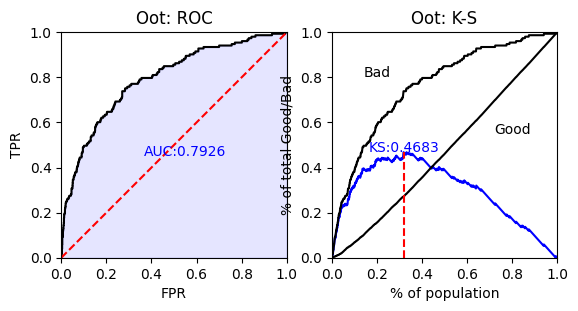

{'KS': 0.4683,
 'AUC': 0.7926,
 'Gini': 0.5852,
 'pic': <Figure size 640x480 with 2 Axes>}

In [19]:
sc.perf_eva(df_test.loc[:, 'y'], best_model.predict_proba(df_test_woe)[:, 1], plot_type=['roc', 'ks'], title='Oot')

In [20]:
df_coef.head()

,var,coef
0,feature_0,-0.575798
1,feature_1,-0.994443
2,feature_4,-1.068297
3,feature_9,-0.944405
4,feature_12,-0.957070


iteration 1
remaining variable number 21


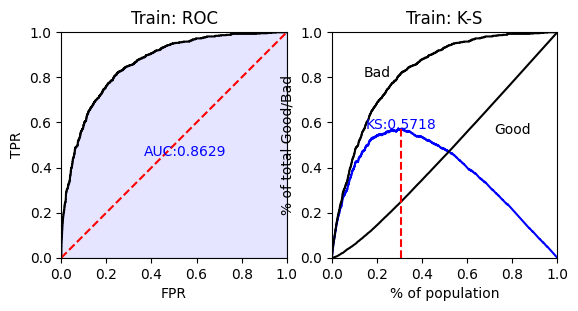

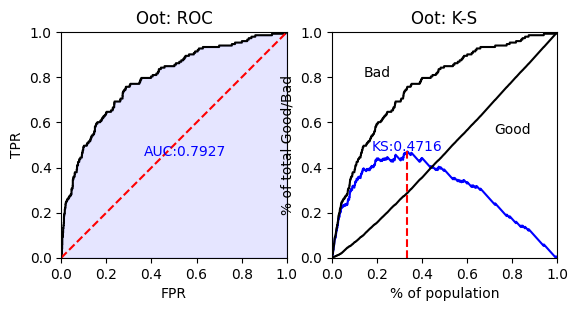

In [23]:
# 处理coef方向不对问题

pdo = 20
target_score = 500
target_odds = 1 / 20
i = 1

while True:
    print(f'iteration {i}')
    initial_n_vars = len(vars_to_keep)

    print(f'remaining variable number {initial_n_vars}')

    model_exp3 = LogisticRegression(solver='liblinear', penalty='l1', C=best_C)
    model_exp3.fit(df_train_woe.loc[:, vars_to_keep], df_train.loc[:, 'y'])

    df_coef_exp3 = pd.DataFrame({'var': vars_to_keep, 'coef': model_exp3.coef_[0]})
    df_coef_exp3.merge(df_coef, how='left', on='var')

    sc.perf_eva(df_train.loc[:, 'y'], model_exp3.predict_proba(df_train_woe.loc[:, vars_to_keep])[:, 1], plot_type=['roc', 'ks'],
                title='Train')
    sc.perf_eva(df_test.loc[:, 'y'], model_exp3.predict_proba(df_test_woe.loc[:, vars_to_keep])[:, 1], plot_type=['roc', 'ks'], title='Oot')

    A = target_score - pdo / np.log(2) * np.log(target_odds)

    score_intercept = A - pdo / np.log(2) * model_exp3.intercept_[0]

    list_score_table = []

    for var_bin in vars_to_keep:
        df_binning = binning_process.get_binned_variable(var_bin).binning_table.build(add_totals=False)

        df_binning.loc[:, 'Variable'] = var_bin

        df_binning.loc[:, 'Coef'] = df_coef_exp3.loc[df_coef_exp3.loc[:, 'var'] == var_bin, 'coef'].values[0]

        df_binning.loc[:, 'score'] = -pdo / np.log(2) * df_binning.loc[:, 'Coef'] * df_binning.loc[:, 'WoE']

        list_score_table.append(df_binning)

    df_score_table = pd.concat(list_score_table, axis=0)

    df_var_score_range = df_score_table.groupby('Variable', as_index=False).aggregate({'score': ['min', 'max']})
    df_var_score_range.columns = ['Variable', 'score_min', 'score_max']

    final_n_vars = len(vars_to_keep)

    if initial_n_vars == final_n_vars:
        break

In [24]:
df_score_table

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Variable,Coef,score
0,"(-inf, -2.91)",602,0.088529,507,95,0.157807,-0.488738,0.025606,0.003169,feature_0,-0.573355,-8.085458
1,"[-2.91, -2.26)",394,0.057941,350,44,0.111675,-0.089629,0.000482,0.000060,feature_0,-0.573355,-1.482776
2,"[-2.26, -1.78)",432,0.063529,405,27,0.062500,0.544678,0.015190,0.001876,feature_0,-0.573355,9.010901
3,"[-1.78, -0.44)",1548,0.227647,1423,125,0.080749,0.268837,0.014786,0.001843,feature_0,-0.573355,4.447509
4,"[-0.44, 0.96)",1597,0.234853,1453,144,0.090169,0.148200,0.004863,0.000607,feature_0,-0.573355,2.451755
...,...,...,...,...,...,...,...,...,...,...,...,...
1,"[-1.65, 0.05)",3240,0.476471,2926,314,0.096914,0.068626,0.002184,0.000273,feature_48,-0.910473,1.802862
2,"[0.05, 0.20)",415,0.061029,389,26,0.062651,0.542111,0.014470,0.001787,feature_48,-0.910473,14.241619
3,"[0.20, inf)",2794,0.410882,2478,316,0.113099,-0.103907,0.004623,0.000578,feature_48,-0.910473,-2.729718
4,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,feature_48,-0.910473,0.000000


In [26]:
len(df_score_table.Variable.unique())

21

In [28]:
df_score_table.groupby('Variable')["IV"].sum().sort_values(ascending=False)

Variable
feature_32    0.812486
feature_20    0.224435
feature_17    0.214393
feature_45    0.176909
feature_46    0.174550
feature_31    0.148091
feature_0     0.071009
feature_35    0.044777
feature_12    0.037493
feature_42    0.036568
feature_29    0.033779
feature_4     0.032027
feature_15    0.029552
feature_36    0.028592
feature_34    0.026902
feature_19    0.024804
feature_48    0.024732
feature_37    0.024521
feature_9     0.021428
feature_16    0.020084
feature_1     0.020022
Name: IV, dtype: float64